<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/Dan_LOgistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import random
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib',
                      'numpy', 'pandas']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset

In [ ]:
#0. Model methods import
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# adata_m1 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_all_genes.h5ad")
# adata_m2 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_HVGs.h5ad")
# adata_m3 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_no_PC_HVGs.h5ad")

# data_list = [adata_m1, adata_m2, adata_m3]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

adata_m1 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_all_genes_qc.h5ad")
adata_m2 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_HVGs_qc.h5ad")
adata_m3 = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_no_PC_HVGs_qc.h5ad")

data_list = [adata_m1, adata_m2, adata_m3]

Mounted at /content/drive


In [ ]:
adata_m1

AnnData object with n_obs × n_vars = 17858 × 32043
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
df_dan_lr = pd.DataFrame(columns = ['Seed', 'dLR m1 val', 'dLR m2 val', 'dLR m3 val','dLR m1 test', 'dLR m2 test', 'dLR m3 test'])

In [ ]:
dict_list_dan_lr_m1 = []
dict_list_dan_lr_m2 = []
dict_list_dan_lr_m3 = []

In [ ]:
#0. Define Logistic Regression Model
def logisticRegressionTest():

  use_gpu = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_gpu else "cpu")

  model = LogisticRegression()
  model.fit(X_train, y_train)
  prediction_test = model.predict(X_test_global)

  #test accruacy
  accuracy_test = metrics.accuracy_score(y_test, prediction_test)
  print("Test acc = ", metrics.accuracy_score(y_test, prediction_test))

  return prediction_test, accuracy_test

In [ ]:
#0. Define Logistic Regression Model for Validation
def logisticRegressionValidation():

  use_gpu = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_gpu else "cpu")

  model = LogisticRegression()
  model.fit(X_train, y_train)
  prediction_test_val = model.predict(X_val)

  #validation accuracy
  accuracy_val = metrics.accuracy_score(y_val, prediction_test_val)
  print("Validation acc = ", metrics.accuracy_score(y_val, prediction_test_val))

  return prediction_test_val, accuracy_val

In [ ]:
def plot(y_test, prediction_test):
  confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)
  cmd = ConfusionMatrixDisplay(confusion_matrix, display_labels=['Healthy','PD'])
  cmd.plot(cmap = 'YlGnBu', colorbar = False)

  plt.grid(False)

  fig = cmd.ax_.get_figure()
  fig.set_figwidth(3)
  fig.set_figheight(3)
  plt.rcParams["figure.dpi"] = 500
  plt.rcParams["axes.labelcolor"] = 'black' #now useless

  plt.rc('font', size=16)
  # Set the axes title font size
  plt.rc('axes', titlesize=14)
  # Set the axes labels font size
  plt.rc('axes', labelsize=14)
  # Set the font size for x tick labels
  plt.rc('xtick', labelsize=14)
  # Set the font size for y tick labels
  plt.rc('ytick', labelsize=14)
  #plt.savefig(dpi = 300, fname = 'astro_LR.png')

mega-loop!

In [ ]:
i = 0 #method number
import copy
seed_list = []

for dataobj in data_list:

  i = i + 1
  adata = dataobj

  #1. Pre-process data
  if 'level_0' not in adata.obs.columns:
    adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

  if 'X_pca' in adata.obsm:
    X = adata.obsm['X_pca'].X
  else:
    X = adata.X
  y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

  #2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
  #   Parameters for the highest accuracy can be used for test set.

  X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
  #3. run 10 iterations
  for m in range (10):
    X_test = copy.deepcopy(X_test_global)
    y_test = copy.deepcopy(y_test_global)

    if len(seed_list) < 10:
      seed = random.randint(0, 9999)
      seed_list.append(seed)
      print("seed: ", seed)
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
    else:
      print("seed = ", seed)
      print(seed_list[m])
      X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])

    prediction_val, accuracy_val = logisticRegressionValidation()
    prediction_test, accuracy_test = logisticRegressionTest()

    if i == 1: #write in method 1 section
      row_dict_m1 = {'Seed': seed_list[m], 'dLR m1 val': accuracy_val, 'dLR m1 test': accuracy_test}
      dict_list_dan_lr_m1.append(row_dict_m1)
    elif i == 2:
      row_dict_m2 = {'Seed': seed_list[m], 'dLR m2 val': accuracy_val, 'dLR m2 test': accuracy_test}
      dict_list_dan_lr_m2.append(row_dict_m2)
    elif i == 3:
      row_dict_m3 = {'Seed': seed_list[m], 'dLR m3 val': accuracy_val, 'dLR m3 test': accuracy_test}
      dict_list_dan_lr_m3.append(row_dict_m3)

print(dict_list_dan_lr_m1)
print(dict_list_dan_lr_m2)
print(dict_list_dan_lr_m3)

seed:  6095
Validation acc =  0.9916013437849944
Test acc =  0.9890817469204927
seed:  882
Validation acc =  0.9921612541993281
Test acc =  0.9893617021276596
seed:  2306
Validation acc =  0.9902015677491601
Test acc =  0.9896416573348265
seed:  1387
Validation acc =  0.9899216125419933
Test acc =  0.9896416573348265
seed:  6267
Validation acc =  0.9930011198208286
Test acc =  0.9907614781634938
seed:  2336
Validation acc =  0.9899216125419933
Test acc =  0.9890817469204927
seed:  8736
Validation acc =  0.9902015677491601
Test acc =  0.9907614781634938
seed:  4211
Validation acc =  0.9930011198208286
Test acc =  0.9902015677491601
seed:  419
Validation acc =  0.9907614781634938
Test acc =  0.9907614781634938
seed:  5372
Validation acc =  0.9916013437849944


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Test acc =  0.9899216125419933
seed =  5372
6095
Validation acc =  0.9918812989921613
Test acc =  0.9890817469204927
seed =  5372
882
Validation acc =  0.9876819708846585
Test acc =  0.9896416573348265
seed =  5372
2306
Validation acc =  0.990481522956327
Test acc =  0.9893617021276596
seed =  5372
1387
Validation acc =  0.9899216125419933
Test acc =  0.9902015677491601
seed =  5372
6267
Validation acc =  0.9930011198208286
Test acc =  0.9896416573348265
seed =  5372
2336
Validation acc =  0.9854423292273237
Test acc =  0.9899216125419933
seed =  5372
8736
Validation acc =  0.988521836506159
Test acc =  0.9907614781634938
seed =  5372
4211
Validation acc =  0.988521836506159
Test acc =  0.9890817469204927
seed =  5372
419
Validation acc =  0.9893617021276596
Test acc =  0.9902015677491601
seed =  5372
5372
Validation acc =  0.9882418812989922
Test acc =  0.9893617021276596
seed =  5372
6095


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9944008958566629


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9924412094064949
seed =  5372
882


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9921612541993281


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9927211646136618
seed =  5372
2306


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9935610302351624


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9938409854423292
seed =  5372
1387


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9924412094064949


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9935610302351624
seed =  5372
6267


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9941209406494961


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9924412094064949
seed =  5372
2336


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9882418812989922


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9932810750279956
seed =  5372
8736


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9932810750279956


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9924412094064949
seed =  5372
4211


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9913213885778276


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9941209406494961
seed =  5372
419


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9913213885778276


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9930011198208286
seed =  5372
5372


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9918812989921613
Test acc =  0.9924412094064949
[{'Seed': 6095, 'dLR m1 val': 0.9916013437849944, 'dLR m1 test': 0.9890817469204927}, {'Seed': 882, 'dLR m1 val': 0.9921612541993281, 'dLR m1 test': 0.9893617021276596}, {'Seed': 2306, 'dLR m1 val': 0.9902015677491601, 'dLR m1 test': 0.9896416573348265}, {'Seed': 1387, 'dLR m1 val': 0.9899216125419933, 'dLR m1 test': 0.9896416573348265}, {'Seed': 6267, 'dLR m1 val': 0.9930011198208286, 'dLR m1 test': 0.9907614781634938}, {'Seed': 2336, 'dLR m1 val': 0.9899216125419933, 'dLR m1 test': 0.9890817469204927}, {'Seed': 8736, 'dLR m1 val': 0.9902015677491601, 'dLR m1 test': 0.9907614781634938}, {'Seed': 4211, 'dLR m1 val': 0.9930011198208286, 'dLR m1 test': 0.9902015677491601}, {'Seed': 419, 'dLR m1 val': 0.9907614781634938, 'dLR m1 test': 0.9907614781634938}, {'Seed': 5372, 'dLR m1 val': 0.9916013437849944, 'dLR m1 test': 0.9899216125419933}]
[{'Seed': 6095, 'dLR m2 val': 0.9918812989921613, 'dLR m2 test': 0.9890817469204927

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
df_dan_m1 = pd.DataFrame.from_dict(dict_list_dan_lr_m1)
df_dan_m2 = pd.DataFrame.from_dict(dict_list_dan_lr_m2)
df_dan_m3 = pd.DataFrame.from_dict(dict_list_dan_lr_m3)

In [ ]:
f = pd.concat([df_dan_m1, df_dan_m2,df_dan_m3])
f

,Seed,dLR m1 val,dLR m1 test,dLR m2 val,dLR m2 test,dLR m3 val,dLR m3 test
0,6095,0.991601,0.989082,NaN,NaN,NaN,NaN
1,882,0.992161,0.989362,NaN,NaN,NaN,NaN
2,2306,0.990202,0.989642,NaN,NaN,NaN,NaN
3,1387,0.989922,0.989642,NaN,NaN,NaN,NaN
4,6267,0.993001,0.990761,NaN,NaN,NaN,NaN
5,2336,0.989922,0.989082,NaN,NaN,NaN,NaN
6,8736,0.990202,0.990761,NaN,NaN,NaN,NaN
7,4211,0.993001,0.990202,NaN,NaN,NaN,NaN
8,419,0.990761,0.990761,NaN,NaN,NaN,NaN
9,5372,0.991601,0.989922,NaN,NaN,NaN,NaN


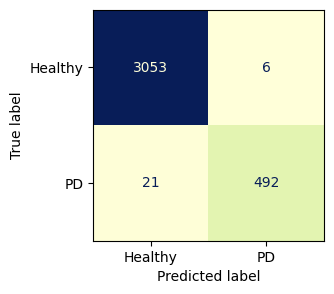

In [ ]:
plot(y_test, prediction_test)

In [ ]:
#there is error!!!
def logisticRegression_final_evaluation(seed):
  if 'X_pca' in adata_m1.obsm:
    X = pd.DataFrame(adata_m1.obsm['X_pca'])
  else:
    X = adata_m1.X

  y = adata_m1.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

  #2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
  #   Parameters for the highest accuracy can be used for test set.

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= seed)

  prediction_test, accuracy_test = logisticRegressionTest()
  return prediction_test, accuracy_test

Test acc =  0.9907614781634938


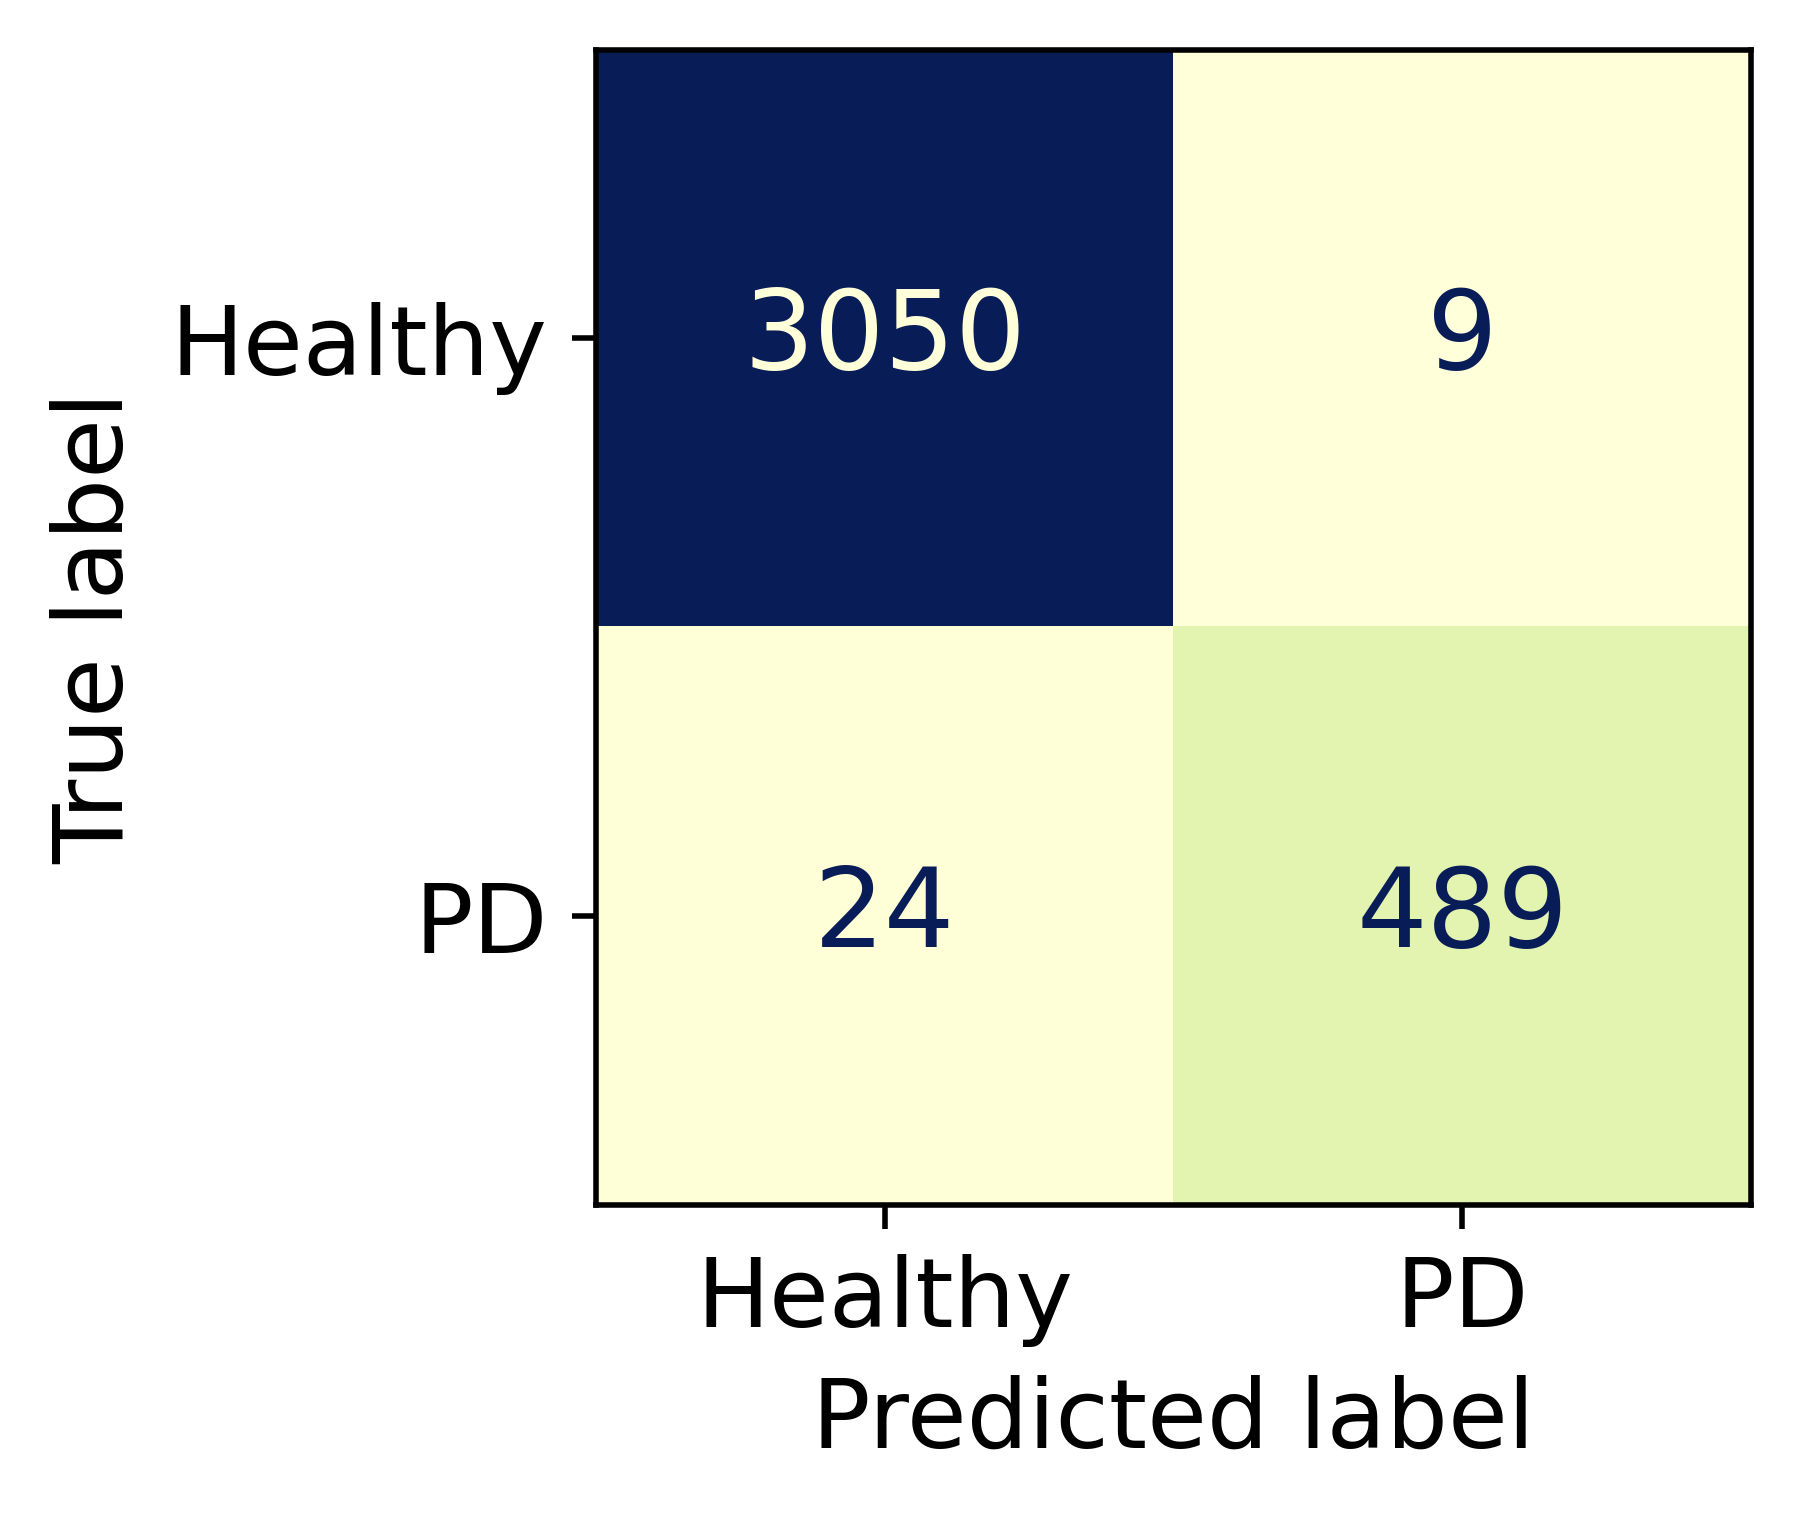

In [ ]:
#4. Re-run Logistic Regression with the seed that generates the highest acc to draw plot
chosenseedm1=df_dan_m1['Seed'][df_dan_m1['dLR m1 test'].idxmax()]
if 'X_pca' in adata_m1.obsm:
  X = adata_m1.obsm['X_pca'].X
else:
  X = adata_m1.X

y = adata_m1.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
#   Parameters for the highest accuracy can be used for test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= chosenseedm1)

prediction_test, accuracy_test = logisticRegressionTest()
plot(y_test, prediction_test)

8736
Test acc =  0.9907614781634938


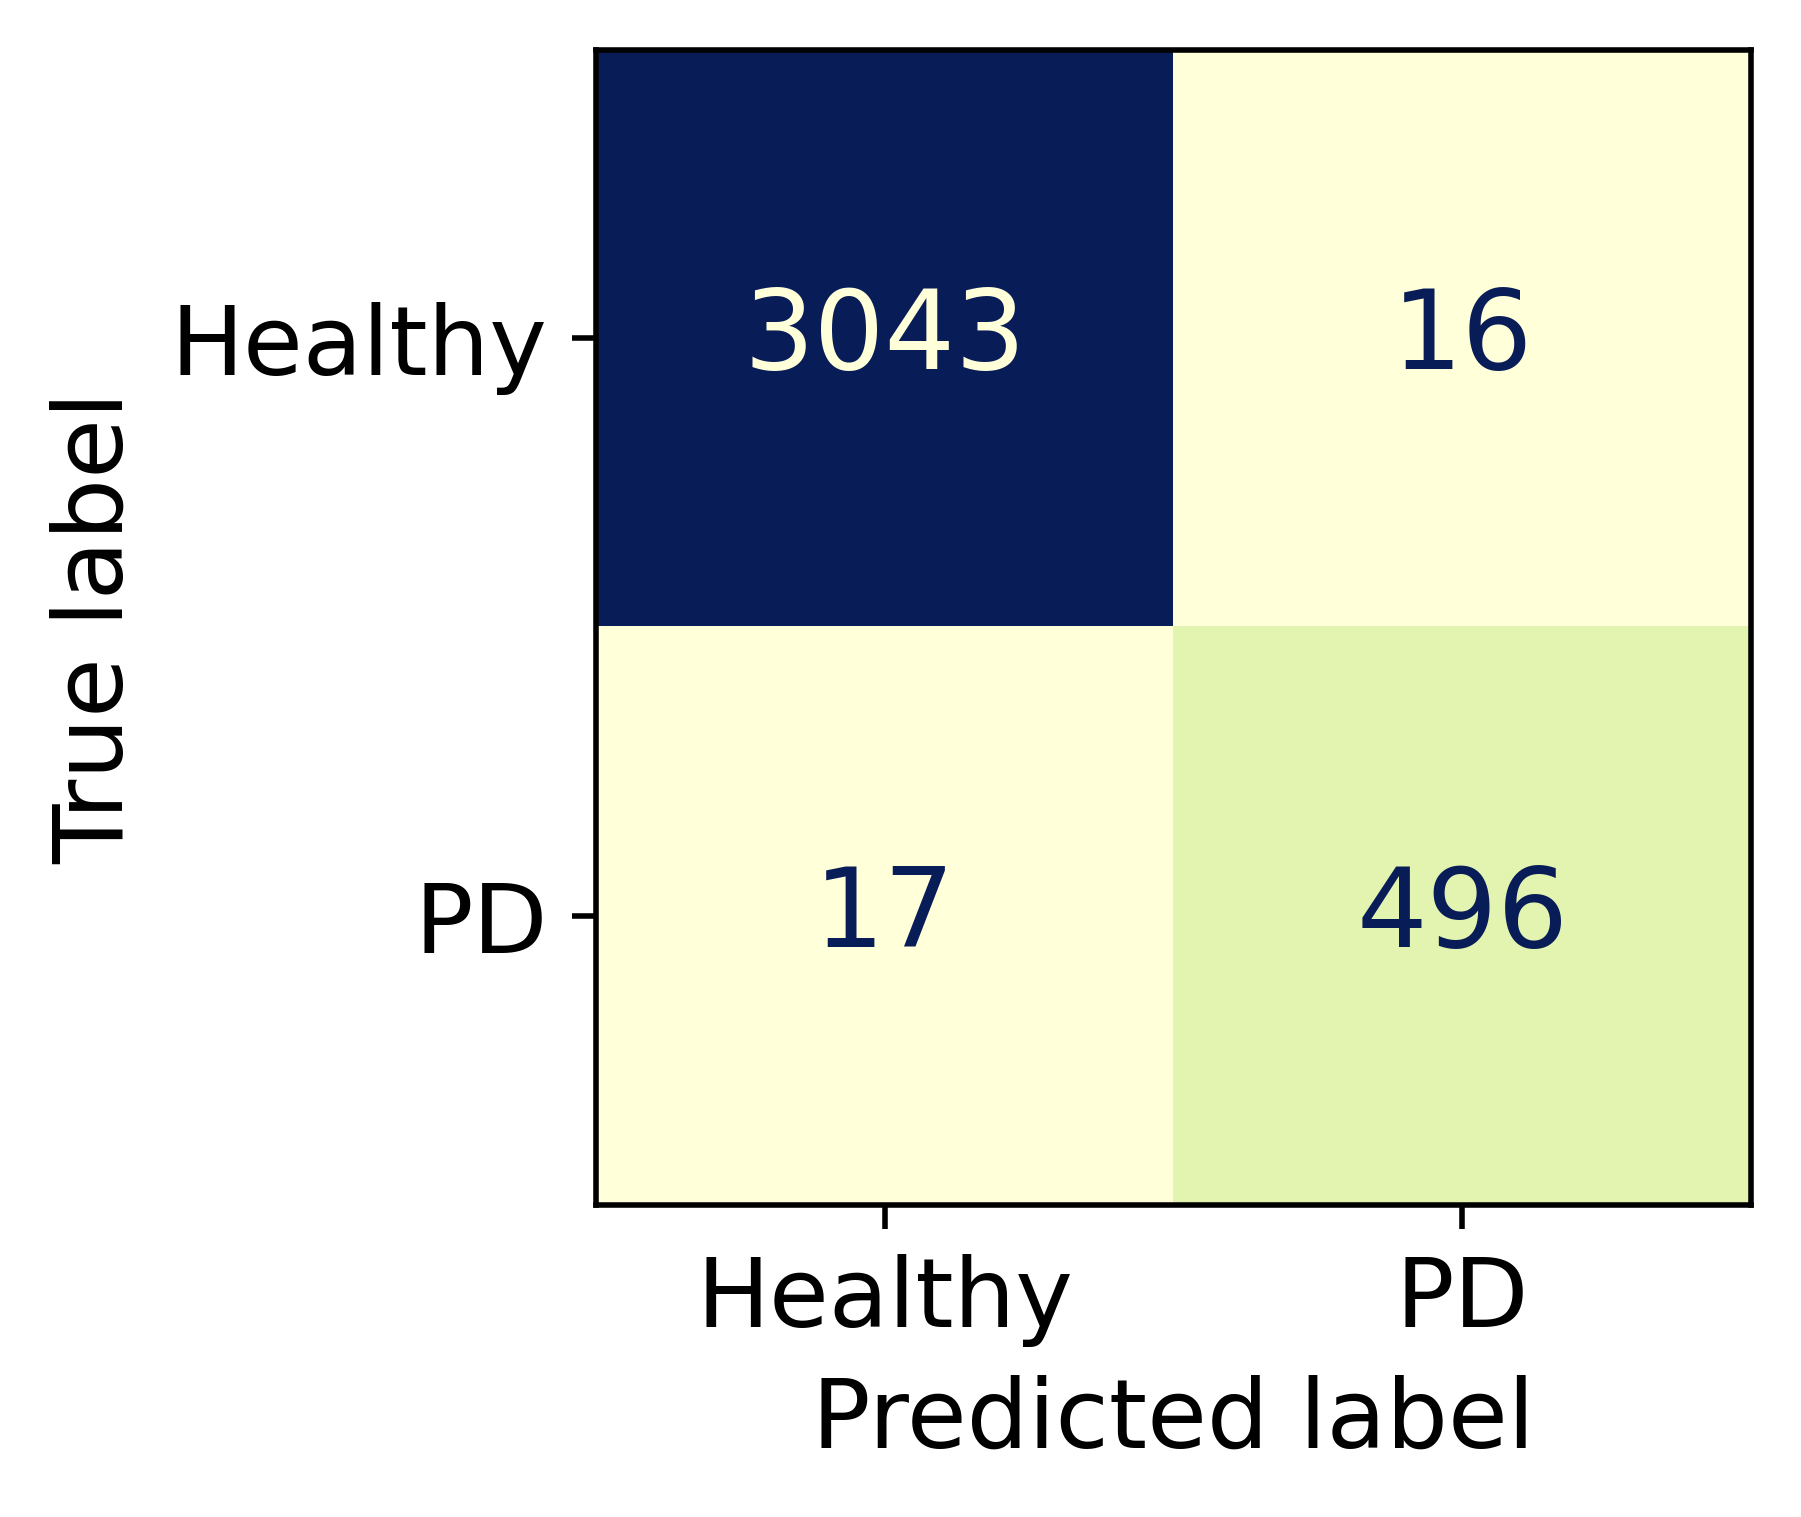

In [ ]:
#4. method 2
chosenseedm2=df_dan_m2['Seed'][df_dan_m2['dLR m2 test'].idxmax()]
print(chosenseedm2)
if 'X_pca' in adata_m2.obsm:
  X = adata_m2.obsm['X_pca'].X
else:
  X = adata_m2.X

y = adata_m2.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
#   Parameters for the highest accuracy can be used for test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= chosenseedm2)

prediction_test, accuracy_test = logisticRegressionTest()
plot(y_test, prediction_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test acc =  0.9941209406494961


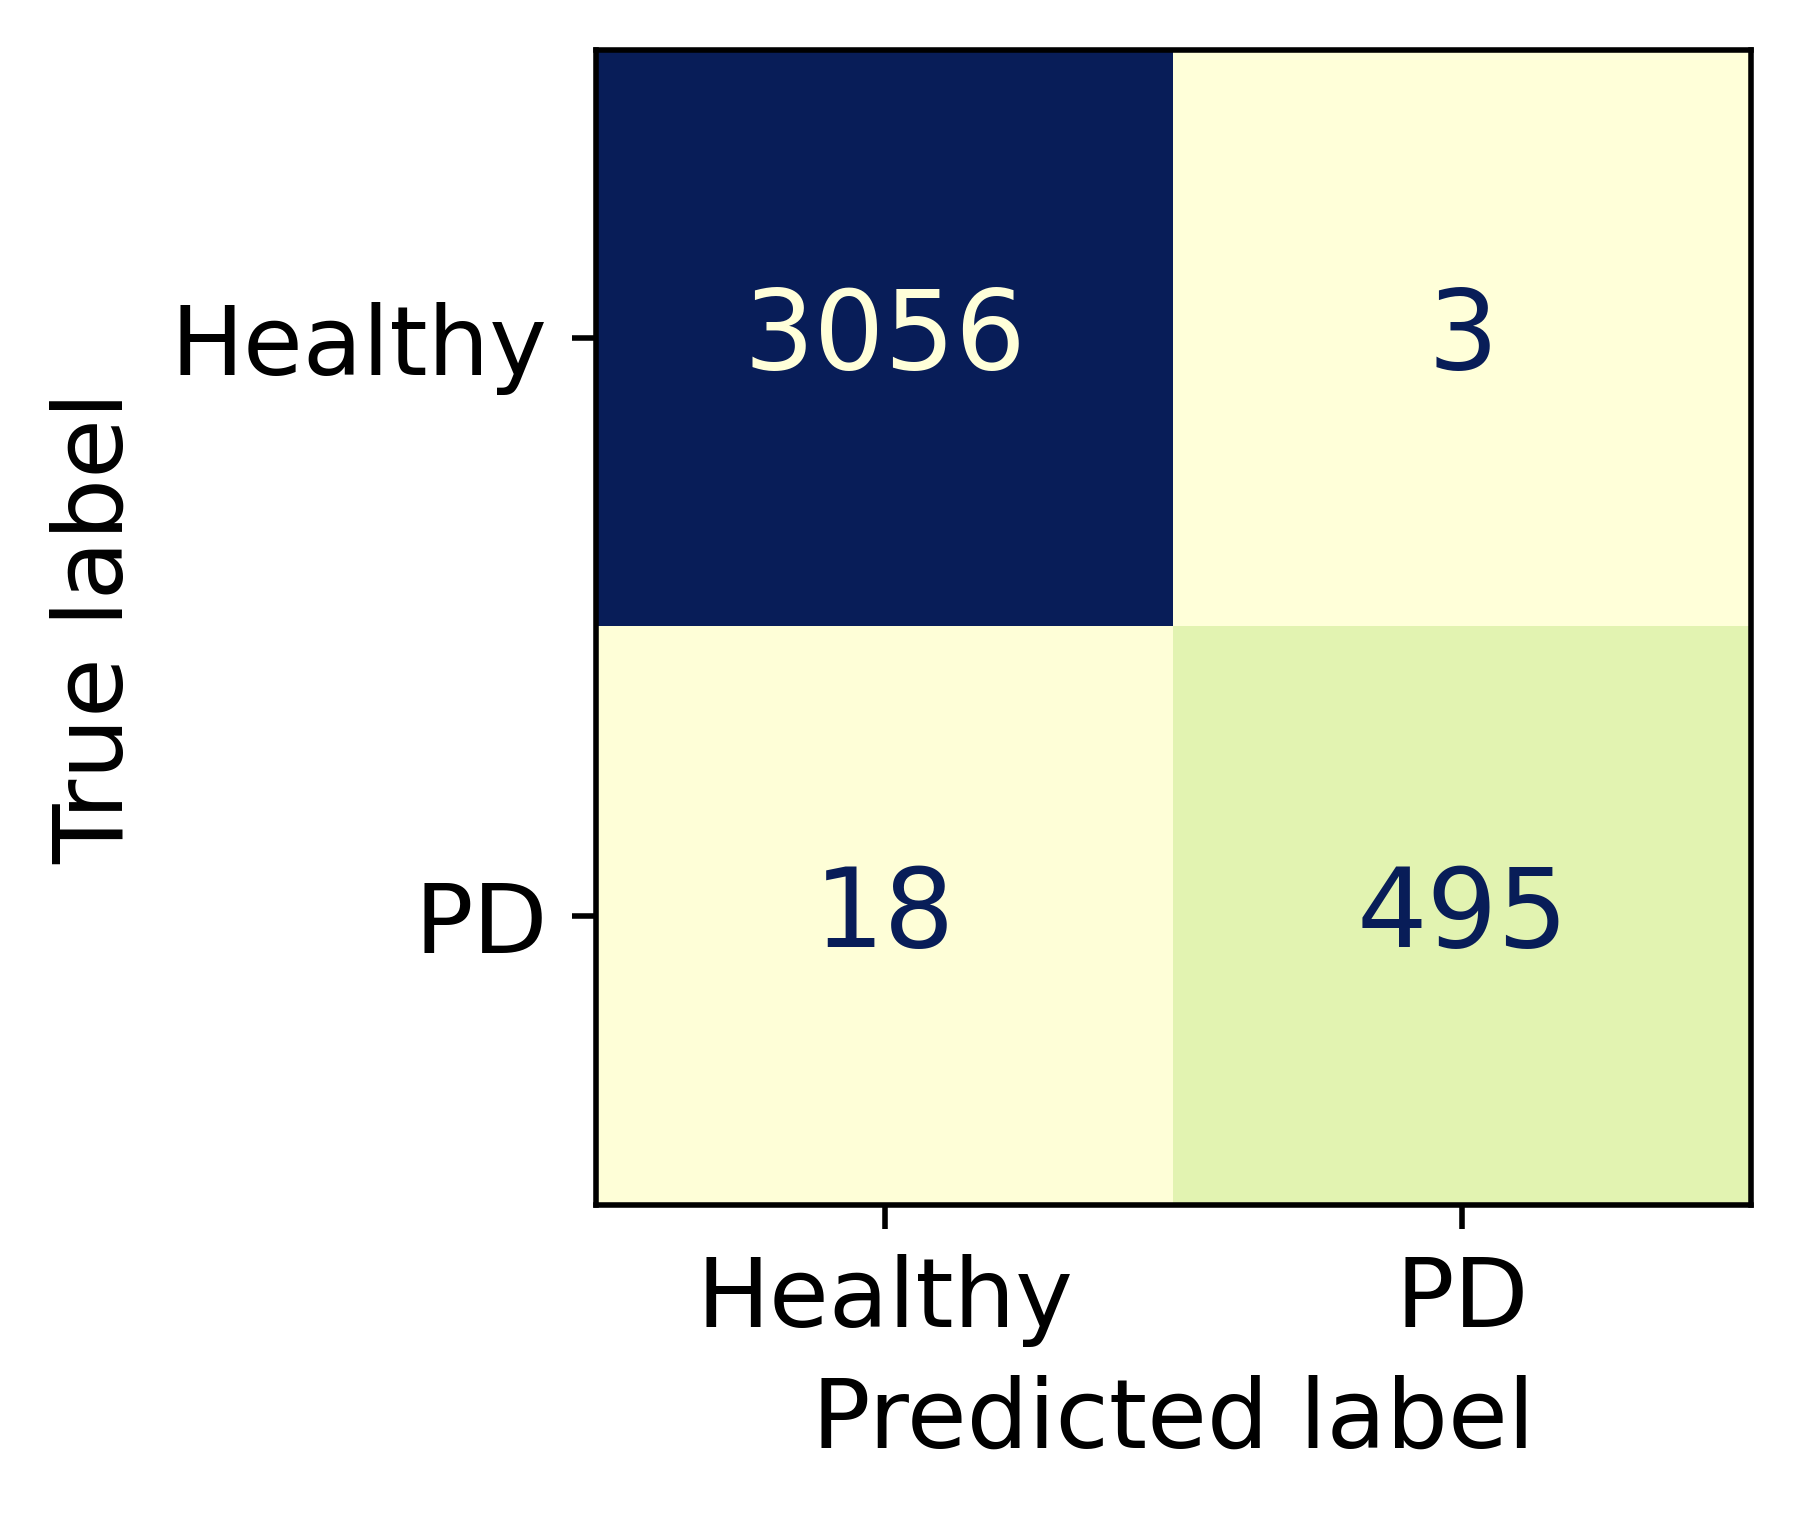

In [ ]:
#4. method 3
chosenseedm3=df_dan_m3['Seed'][df_dan_m3['dLR m3 test'].idxmax()]
if 'X_pca' in adata_m3.obsm:
  X = adata_m3.obsm['X_pca'].X
else:
  X = adata_m3.X

y = adata_m3.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

#2. Train-test split: 60/20/20. Random_state is the seed.Validation used for hyperparameter tuning.
#   Parameters for the highest accuracy can be used for test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= chosenseedm3)

prediction_test, accuracy_test = logisticRegressionTest()
plot(y_test, prediction_test)

In [ ]:
#?  Seed. Is this necessary?
#np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)